#### Q.1) Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas as pd
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import copy
import datetime
from tqdm import tqdm

In [2]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


#### Q.2) Load the given data

In [3]:
df=pd.read_csv('Solar_Energy_Production.csv')
df = df.dropna()

In [4]:
df.head()

,name,id,address,date,kWh,public_url,installationDate,uid
0,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 08:00:00 AM,1.130,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 08:00:00
1,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 09:00:00 AM,2.340,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 09:00:00
2,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 10:00:00 AM,3.656,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 10:00:00
3,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 11:00:00 AM,4.577,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 11:00:00
4,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 12:00:00 PM,6.506,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 12:00:00


In [5]:
print(df.shape[0])

258423


In [6]:
df=df.drop('id',axis=1)
df=df.drop('address',axis=1)
df=df.drop('public_url',axis=1)
df=df.drop('uid',axis=1)


In [7]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df = df.sort_values('date')
df.set_index('date', inplace=True)
df.head()

/tmp/ipykernel_2947647/3983319057.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)


,name,kWh,installationDate
date,,,
2015-09-01 14:30:00,Southland Leisure Centre,27.805,2015/09/01
2015-09-01 15:30:00,Southland Leisure Centre,30.559,2015/09/01
2015-09-01 16:30:00,Southland Leisure Centre,23.613,2015/09/01
2015-09-01 17:30:00,Southland Leisure Centre,15.257,2015/09/01
2015-09-01 18:30:00,Southland Leisure Centre,7.896,2015/09/01


In [8]:
inst=df['installationDate']
df=df.drop('installationDate',axis=1)
inst=pd.Series(inst)
inst

date
2015-09-01 14:30:00    2015/09/01
2015-09-01 15:30:00    2015/09/01
2015-09-01 16:30:00    2015/09/01
2015-09-01 17:30:00    2015/09/01
2015-09-01 18:30:00    2015/09/01
                          ...    
2023-03-16 19:00:00    2016/12/21
2023-03-16 19:00:00    2017/09/13
2023-03-16 19:00:00    2017/10/31
2023-03-16 19:00:00    2017/10/23
2023-03-16 19:00:00    2016/11/07
Name: installationDate, Length: 258423, dtype: object

In [9]:
inst= inst.str.split('/', expand=True)
inst.columns = ['yy','mm','dd']
inst= inst.astype(int)
inst

,yy,mm,dd
date,,,
2015-09-01 14:30:00,2015,9,1
2015-09-01 15:30:00,2015,9,1
2015-09-01 16:30:00,2015,9,1
2015-09-01 17:30:00,2015,9,1
2015-09-01 18:30:00,2015,9,1
...,...,...,...
2023-03-16 19:00:00,2016,12,21
2023-03-16 19:00:00,2017,9,13
2023-03-16 19:00:00,2017,10,31


In [10]:
'''Here, I converted the date and time details to datetime object and various features are created using the
details of hour,week of year,etc.'''
df['hour']=df.index.hour
df['month']=df.index.month
df['quarter']=df.index.quarter
df['day']=df.index.day
df['day_of_week']=df.index.day_name()
df['week_of_year'] = df.index.isocalendar().week

In [11]:
df.head()

,name,kWh,hour,month,quarter,day,day_of_week,week_of_year
date,,,,,,,,
2015-09-01 14:30:00,Southland Leisure Centre,27.805,14,9,3,1,Tuesday,36
2015-09-01 15:30:00,Southland Leisure Centre,30.559,15,9,3,1,Tuesday,36
2015-09-01 16:30:00,Southland Leisure Centre,23.613,16,9,3,1,Tuesday,36
2015-09-01 17:30:00,Southland Leisure Centre,15.257,17,9,3,1,Tuesday,36
2015-09-01 18:30:00,Southland Leisure Centre,7.896,18,9,3,1,Tuesday,36


In [12]:
'''This function is used to extract periodicity of the various features of the data'''
def generate_cyclical_features(df, col_name, period, start_num=0):
    kwargs = {
        f'sin_{col_name}' : lambda x: np.sin(2*np.pi*(df[col_name]-start_num)/period),
        f'cos_{col_name}' : lambda x: np.cos(2*np.pi*(df[col_name]-start_num)/period)    
             }
    return df.assign(**kwargs)


In [13]:
df = generate_cyclical_features(df, 'hour', 24, 0)
df = generate_cyclical_features(df, 'quarter',4, 1)
df = generate_cyclical_features(df, 'month', 12, 1)
df = generate_cyclical_features(df, 'week_of_year', 52, 0)

df.head()

,name,kWh,hour,month,quarter,day,day_of_week,week_of_year,sin_hour,cos_hour,sin_quarter,cos_quarter,sin_month,cos_month,sin_week_of_year,cos_week_of_year
date,,,,,,,,,,,,,,,,
2015-09-01 14:30:00,Southland Leisure Centre,27.805,14,9,3,1,Tuesday,36,-0.500000,-8.660254e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605
2015-09-01 15:30:00,Southland Leisure Centre,30.559,15,9,3,1,Tuesday,36,-0.707107,-7.071068e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605
2015-09-01 16:30:00,Southland Leisure Centre,23.613,16,9,3,1,Tuesday,36,-0.866025,-5.000000e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605
2015-09-01 17:30:00,Southland Leisure Centre,15.257,17,9,3,1,Tuesday,36,-0.965926,-2.588190e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605
2015-09-01 18:30:00,Southland Leisure Centre,7.896,18,9,3,1,Tuesday,36,-1.000000,-1.836970e-16,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605


In [14]:
inst = generate_cyclical_features(inst, 'mm', 12, 1)
inst.head()

,yy,mm,dd,sin_mm,cos_mm
date,,,,,
2015-09-01 14:30:00,2015,9,1,-0.866025,-0.5
2015-09-01 15:30:00,2015,9,1,-0.866025,-0.5
2015-09-01 16:30:00,2015,9,1,-0.866025,-0.5
2015-09-01 17:30:00,2015,9,1,-0.866025,-0.5
2015-09-01 18:30:00,2015,9,1,-0.866025,-0.5


In [15]:
b=pd.get_dummies(inst['mm']).astype('int')
inst=pd.concat([b, inst], axis=1)
inst=inst.drop('mm',axis=1)
b=pd.get_dummies(inst['dd']).astype('int')
inst=pd.concat([b,inst],axis=1)
inst=inst.drop('dd',axis=1)
inst=inst.drop('yy',axis=1)
inst.head()

,1,7,11,13,21,23,25,27,31,1,9,10,11,12,sin_mm,cos_mm
date,,,,,,,,,,,,,,,,
2015-09-01 14:30:00,1,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.866025,-0.5
2015-09-01 15:30:00,1,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.866025,-0.5
2015-09-01 16:30:00,1,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.866025,-0.5
2015-09-01 17:30:00,1,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.866025,-0.5
2015-09-01 18:30:00,1,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.866025,-0.5


In [16]:
'''Here,one-hot encoding is performed for the categorical features'''
a=pd.get_dummies(df['day_of_week']).astype('int')
df=pd.concat([df, a], axis=1)
df = df.drop('day_of_week', axis=1)
a=pd.get_dummies(df['hour']).astype('int')
df=pd.concat([df, a], axis=1)
df = df.drop('hour', axis=1)
a=pd.get_dummies(df['week_of_year']).astype('int')
df=pd.concat([df, a], axis=1)
df = df.drop('week_of_year', axis=1)
a=pd.get_dummies(df['month']).astype('int')
df=pd.concat([df, a], axis=1)
df = df.drop('month', axis=1)
a=pd.get_dummies(df['day']).astype('int')
df=pd.concat([df, a], axis=1)
df = df.drop('day', axis=1)
a=pd.get_dummies(df['name']).astype('int')
df=pd.concat([df, a], axis=1)
df = df.drop('name', axis=1)

In [17]:
df.head()

,kWh,quarter,sin_hour,cos_hour,sin_quarter,cos_quarter,sin_month,cos_month,sin_week_of_year,cos_week_of_year,...,CFD Firehall #7,Calgary Fire Hall Headquarters,City of Calgary North Corporate Warehouse,Glenmore Water Treatment Plant,Hillhurst Sunnyside Community Association,Manchester Building M,Richmond - Knob Hill Community Hall,Southland Leisure Centre,Telus Spark,Whitehorn Multi-Service Centre
date,,,,,,,,,,,,,,,,,,,,,
2015-09-01 14:30:00,27.805,3,-0.500000,-8.660254e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605,...,0,0,0,0,0,0,0,1,0,0
2015-09-01 15:30:00,30.559,3,-0.707107,-7.071068e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605,...,0,0,0,0,0,0,0,1,0,0
2015-09-01 16:30:00,23.613,3,-0.866025,-5.000000e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605,...,0,0,0,0,0,0,0,1,0,0
2015-09-01 17:30:00,15.257,3,-0.965926,-2.588190e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605,...,0,0,0,0,0,0,0,1,0,0
2015-09-01 18:30:00,7.896,3,-1.000000,-1.836970e-16,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605,...,0,0,0,0,0,0,0,1,0,0


In [18]:
df=pd.concat([df,inst],axis=1)
df.head()

,kWh,quarter,sin_hour,cos_hour,sin_quarter,cos_quarter,sin_month,cos_month,sin_week_of_year,cos_week_of_year,...,25,27,31,1,9,10,11,12,sin_mm,cos_mm
date,,,,,,,,,,,,,,,,,,,,,
2015-09-01 14:30:00,27.805,3,-0.500000,-8.660254e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605,...,0,0,0,0,1,0,0,0,-0.866025,-0.5
2015-09-01 15:30:00,30.559,3,-0.707107,-7.071068e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605,...,0,0,0,0,1,0,0,0,-0.866025,-0.5
2015-09-01 16:30:00,23.613,3,-0.866025,-5.000000e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605,...,0,0,0,0,1,0,0,0,-0.866025,-0.5
2015-09-01 17:30:00,15.257,3,-0.965926,-2.588190e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605,...,0,0,0,0,1,0,0,0,-0.866025,-0.5
2015-09-01 18:30:00,7.896,3,-1.000000,-1.836970e-16,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605,...,0,0,0,0,1,0,0,0,-0.866025,-0.5


In [19]:
print(df.shape)
df.columns = df.columns.astype(str)
df.head()

(258423, 164)


,kWh,quarter,sin_hour,cos_hour,sin_quarter,cos_quarter,sin_month,cos_month,sin_week_of_year,cos_week_of_year,...,25,27,31,1,9,10,11,12,sin_mm,cos_mm
date,,,,,,,,,,,,,,,,,,,,,
2015-09-01 14:30:00,27.805,3,-0.500000,-8.660254e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605,...,0,0,0,0,1,0,0,0,-0.866025,-0.5
2015-09-01 15:30:00,30.559,3,-0.707107,-7.071068e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605,...,0,0,0,0,1,0,0,0,-0.866025,-0.5
2015-09-01 16:30:00,23.613,3,-0.866025,-5.000000e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605,...,0,0,0,0,1,0,0,0,-0.866025,-0.5
2015-09-01 17:30:00,15.257,3,-0.965926,-2.588190e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605,...,0,0,0,0,1,0,0,0,-0.866025,-0.5
2015-09-01 18:30:00,7.896,3,-1.000000,-1.836970e-16,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605,...,0,0,0,0,1,0,0,0,-0.866025,-0.5


In [20]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled)
df_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,154,155,156,157,158,159,160,161,162,163
0,0.054047,0.666667,0.250000,0.066987,0.5,0.0,0.066987,0.25,0.032492,0.322698,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.133975,0.0
1,0.059400,0.666667,0.146447,0.146447,0.5,0.0,0.066987,0.25,0.032492,0.322698,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.133975,0.0
2,0.045898,0.666667,0.066987,0.250000,0.5,0.0,0.066987,0.25,0.032492,0.322698,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.133975,0.0
3,0.029656,0.666667,0.017037,0.370590,0.5,0.0,0.066987,0.25,0.032492,0.322698,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.133975,0.0
4,0.015348,0.666667,0.000000,0.500000,0.5,0.0,0.066987,0.25,0.032492,0.322698,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.133975,0.0


In [21]:
def prepare_data(data,sequence_length):
    '''Here, this function generates time-lagged observations of data and prepares dependent 
    and independent features by shifting the given data.'''
    y = []
    x = []

    for i in range(len(data) - sequence_length):
        x.append(data.iloc[i:i + sequence_length].values)
        y.append(data.iloc[i + sequence_length, 0])
    x = np.array(x)
    y = np.array(y)

        
    return x,y

In [22]:
x, y = prepare_data(df_scaled,100)

In [23]:
print(x.shape)
print(y.shape)

(258323, 100, 164)
(258323,)


In [24]:
df.shape #First 100 data points are omitted as they doesnt contain the previous values

(258423, 164)

In [25]:
x_train = x[:210000]
y_train = y[:210000]
x_test = x[210000:]
y_test = y[210000:]

In [26]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(210000, 100, 164)
(48323, 100, 164)
(210000,)
(48323,)


In [27]:
'''Initializing tensors'''
x_train = torch.tensor(x_train,dtype=torch.float32)
x_test = torch.tensor(x_test,dtype=torch.float32)
y_train = torch.tensor(y_train,dtype=torch.float32)
y_test = torch.tensor(y_test,dtype=torch.float32)

In [28]:
class RNN(nn.Module):
    """
    This class defines a simple recurrent neural network model (vanilla/elman RNN) which is used here for the 
    prediction of given univariate time-series data.
    
    Parameters:
    input_dim: Dimensionality of input tensor which is the size of the input vector at each time step (here, 164).
    hidden_dim: Dimensionality of the hidden state tensor which is the size of the hidden vector passed from one
    timestep to the next (ht-1).
    layer_dim: The number of RNN layers in the network. A layer contains a set of recurrent cells that process the 
    input and hidden states to generate the outputs and new hidden states.
    output_dim: Dimensionality of the output tensor (here, 1 for predicting Power).
    """
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim
        
        
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, dropout = 0.1, nonlinearity = 'relu')
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """
        Forward propagation.
        
        Parameters:
        x: Input tensor
        
        Returns:
        out: Output tensor
        """
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        out, hn = self.rnn(x, h0)
        
        out = out[:, -1, :]
        out = self.fc(out)
        
        return out
    

In [29]:
def dataloader(x_data, y_data, batch_size):
    
    dataset = TensorDataset(torch.tensor(x_data, dtype=torch.float32), torch.tensor(y_data, dtype=torch.float32))
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [30]:
def training(model, learning_rate, epochs, weight_decay, batch_size, train_loader, val_loader, input_dim, device, lag=100):
    """
    This function trains the model and evaluates its performance using Mean Squared Error loss and R2-score.
    
    Parameters:
    model (torch.nn.Module): The neural network model to train.
    learning_rate (float): Learning rate for the optimizer.
    epochs (int): Number of training epochs.
    weight_decay (float): Weight decay for the optimizer.
    batch_size (int): Batch size for training.
    train_loader (torch.utils.data.DataLoader): DataLoader for training data.
    val_loader (torch.utils.data.DataLoader): DataLoader for validation data.
    input_dim (int): Dimensionality of input features.
    device (torch.device): Device to train the model on (CPU or GPU).
    lag (int): Number of timesteps in each sequence.
    
    Returns:
    training_losses (list): List of training losses for each epoch.
    validation_losses (list): List of validation losses for each epoch.
    r2_train (list): List of R2 scores for training data for each epoch.
    r2_val (list): List of R2 scores for validation data for each epoch.
    """
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    training_losses = []
    validation_losses = []
    r2_train = []
    r2_val = []
    
    for epoch in range(1, epochs + 1):
        model.train()
        batch_losses = []
        batch_r2 = []
        
        for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", unit="batch"):
            x_batch = x_batch.view(-1, lag, input_dim).to(device)
            y_batch = y_batch.to(device).unsqueeze(1)
            
            optimizer.zero_grad()
            yhat_batch = model(x_batch)
            loss = criterion(y_batch, yhat_batch)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
            r2score_train = r2_score(y_batch.detach().cpu().numpy(), yhat_batch.detach().cpu().numpy())
            batch_r2.append(r2score_train)
        
        epoch_loss = np.sum(batch_losses)
        training_losses.append(epoch_loss)
        r2_train.append(np.mean(batch_r2))
        
        model.eval()
        with torch.no_grad():
            batch_val_losses = []
            batch_val_r2 = []
            
            for x_val, y_val in tqdm(val_loader, desc=f"Validation {epoch}/{epochs}", unit="batch"):
                x_val = x_val.view(-1, lag, input_dim).to(device)
                y_val = y_val.to(device).unsqueeze(1)
                
                yhat_val = model(x_val)
                val_loss = criterion(y_val, yhat_val)
                
                batch_val_losses.append(val_loss.item())
                r2score_val = r2_score(y_val.detach().cpu().numpy(), yhat_val.detach().cpu().numpy())
                batch_val_r2.append(r2score_val)
            
            validation_loss = np.sum(batch_val_losses)
            validation_losses.append(validation_loss)
            r2_val.append(np.mean(batch_val_r2))
        
        print(f"[{epoch}/{epochs}] Training loss: {epoch_loss:.4f} Validation loss: {validation_loss:.4f} R2 Train: {r2_train[-1]:.4f} R2 Val: {r2_val[-1]:.4f}")
    
    return training_losses, validation_losses, r2_train, r2_val


In [31]:
# Plotting function
def plot_loss(train_loss, val_loss):
    plt.style.use('ggplot')
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


/home/user/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/tmp/ipykernel_2947647/3815620141.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(x_data, dtype=torch.float32), torch.tensor(y_data, dtype=torch.float32))
Validation 1/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:01<00:00, 165.44batch/s]


[1/10] Training loss: 12.9052 Validation loss: 2.3497 R2 Train: 0.2114 R2 Val: 0.2138


Validation 2/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:01<00:00, 160.06batch/s]


[2/10] Training loss: 11.9793 Validation loss: 2.2317 R2 Train: 0.2667 R2 Val: 0.2590


Validation 3/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:01<00:00, 153.06batch/s]


[3/10] Training loss: 11.7899 Validation loss: 2.2029 R2 Train: 0.2789 R2 Val: 0.2649


Validation 4/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:01<00:00, 156.85batch/s]


[4/10] Training loss: 11.6595 Validation loss: 2.1776 R2 Train: 0.2876 R2 Val: 0.2735


Validation 5/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:01<00:00, 165.28batch/s]


[5/10] Training loss: 11.6015 Validation loss: 2.1943 R2 Train: 0.2892 R2 Val: 0.2645


Validation 6/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:01<00:00, 167.43batch/s]


[6/10] Training loss: 11.5283 Validation loss: 2.1748 R2 Train: 0.2935 R2 Val: 0.2709


Validation 7/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:01<00:00, 163.00batch/s]


[7/10] Training loss: 11.4677 Validation loss: 2.1592 R2 Train: 0.2992 R2 Val: 0.2823


Validation 8/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:01<00:00, 168.13batch/s]


[8/10] Training loss: 11.4136 Validation loss: 2.1798 R2 Train: 0.3014 R2 Val: 0.2722


Validation 9/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:01<00:00, 164.86batch/s]


[9/10] Training loss: 11.3402 Validation loss: 2.1861 R2 Train: 0.3056 R2 Val: 0.2704


Validation 10/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:01<00:00, 167.38batch/s]


[10/10] Training loss: 11.2873 Validation loss: 2.1832 R2 Train: 0.3095 R2 Val: 0.2733


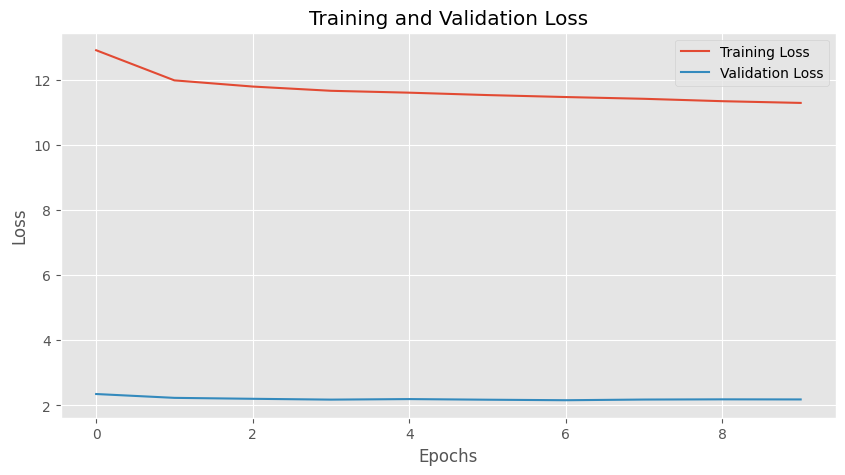

In [33]:
'''training the model'''
'''This model is flexible to change the number of hidden layers and number of neurons in the hidden layers also.
There is a fully connected layer and the number of neurons is given as one since we need a single prediction.
Based on the requirements, it can also be changed as well.
The data loader function can be used to'''

input_dim = x_train.shape[2]
output_dim = 1
hidden_dim = 128
layer_dim = 1
batch_size = 256
epochs = 10
learning_rate = 1e-3
weight_decay = 1e-5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RNN(input_dim, hidden_dim, layer_dim, output_dim).to(device)

train_loader = dataloader(x_train, y_train, batch_size)
val_loader = dataloader(x_test, y_test, batch_size)

train_loss, validation_loss, r2_train, r2_val = training(model, learning_rate, epochs, weight_decay, batch_size, train_loader, val_loader, input_dim, device)

plot_loss(train_loss, validation_loss)

In [34]:
def plot_r2score(r2_train,r2_val):
    plt.figure(figsize=(5,3))
    plt.plot(r2_train,label='R2-score(train)')
    plt.plot(r2_val,label='R2-score(validation)')
    plt.legend()
    plt.title('R2-SCORE')
    plt.show()
    plt.close()
        

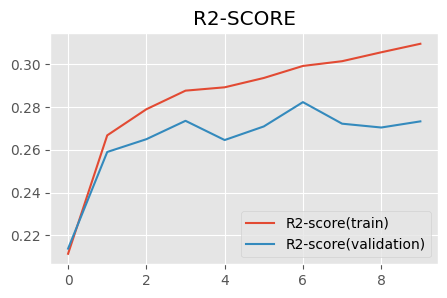

In [35]:
plot_r2score(r2_train,r2_val)

In [54]:
test_loader = dataloader(x_test, y_test, batch_size=64)
criterion = nn.MSELoss()
lag = 100
input_dim = 164
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64

test_loss = []
test_r2 = []
y_pred = torch.zeros(y_test.shape[0], 1, dtype=torch.float32).to(device)
model.eval()

with torch.no_grad():
    for i, (x_test_batch, y_test_batch) in enumerate(test_loader):
        x_test_batch = x_test_batch.view(-1, lag, input_dim).to(device)
        y_test_batch = y_test_batch.to(device).unsqueeze(1)  # Ensure y_test_batch is of shape (batch_size, 1)
        
        yhat_test = model(x_test_batch)

        start_index = i * batch_size
        end_index = start_index + yhat_test.size(0)
        y_pred[start_index:end_index] = yhat_test

        testbatchloss = criterion(y_test_batch, yhat_test)
        test_loss.append(testbatchloss.item())
        r2score_test = r2_score(y_test_batch.detach().cpu().numpy(), yhat_test.detach().cpu().numpy())
        test_r2.append(r2score_test)

testing_loss = np.mean(test_loss)
test_r2_mean = np.mean(test_r2)

print(f'The mean square error loss of given test data is {testing_loss}')
print(f'The R2-score of given test data is {test_r2_mean}')
print(f'The root mean square error loss of given test data is {testing_loss**(1/2)}')

/tmp/ipykernel_2947647/3815620141.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(x_data, dtype=torch.float32), torch.tensor(y_data, dtype=torch.float32))


The mean square error loss of given test data is 0.011540556805412822
The R2-score of given test data is 0.22183476735359778
The root mean square error loss of given test data is 0.10742698360008449


In [56]:
print(y_test.shape)
print(y_pred.shape)

torch.Size([48323])
torch.Size([48323, 1])


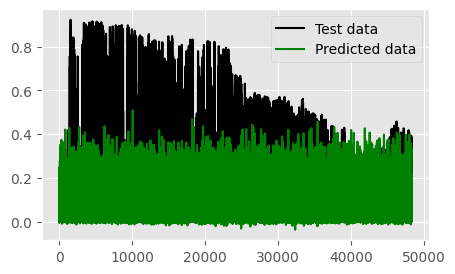

In [58]:
'''plotting the patterns of test and predicted data'''
plt.figure(figsize=(5,3))
plt.plot(y_test.detach().cpu().numpy(),label='Test data',color='black')
plt.plot(y_pred.detach().cpu().numpy(),color='g',label='Predicted data')
plt.legend()
plt.show()